# Ensamble de Clasificadores

La idea clave en los ensambles es lograr **diversidad** en los clasificadores del conjunto. Esta diversidad puede lograrse de distintas maneras. 
El método más común consiste en usar distintos conjuntos de entrenamiento para entrenar clasificadores individuales. Estos conjuntos se pueden obtener mediante muestreo aleatorio de los datos de entrenamiento.

Todos los ensambles deben tener 2 componentes principales: Un algoritmo para generar clasificadores diversos y un método para combinar las salidas de los clasificadores. El método más comun para combinar las salidas es la **votación por mayoría**

## Bagging (Bootstrap aggregation)
En esta estrategia, la diversidad del ensamble se obtiene mediante subconjuntos muestreados de forma aleatoria del conjunto de datos original con reemplazo (pueden repetirse los datos). Estos subconjuntos, se utilizan para entrenar diferentes clasificadores del mismo tipo. La predicción final, se obtiene a partir de las predicciones individuales utilizando en general **_votación por mayoría_**.
<pre>
<center><img src="https://drive.google.com/uc?export=view&id=1dVQmvpA65hbJEgHmnkCcmgskd98PEqaR" width=500></center>
</pre>
El proceso de muestreo de los datos con reemplazo se denomina **Bootstrap**

> Cuando el muestreo se realiza con reemplazo, el método se denomina **Bagging** (boostrap aggregating). Cuando el muestreo se hace sin reemplazo se denomina **Pasting**

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from utiles import plot_decision_regions
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Creamos datos 
X, y = make_moons(n_samples=500, noise=0.30, random_state=0) # 500 muestras, 0.30 ruido(dispersion), 0 semilla
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)


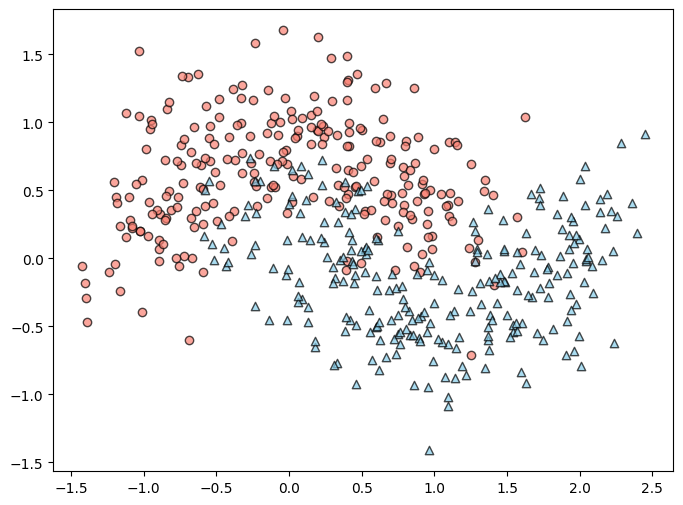

In [2]:
# Visualizamos los datos
markers = ('o', '^', 'v')
colors = ('salmon','skyblue','red', 'gray', 'cyan')
plt.figure(figsize=(8,6))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], 
                y=X[y == cl, 1],
                alpha=0.7, 
                c=colors[idx],
                marker=markers[idx], 
                label=cl, 
                edgecolor='black')

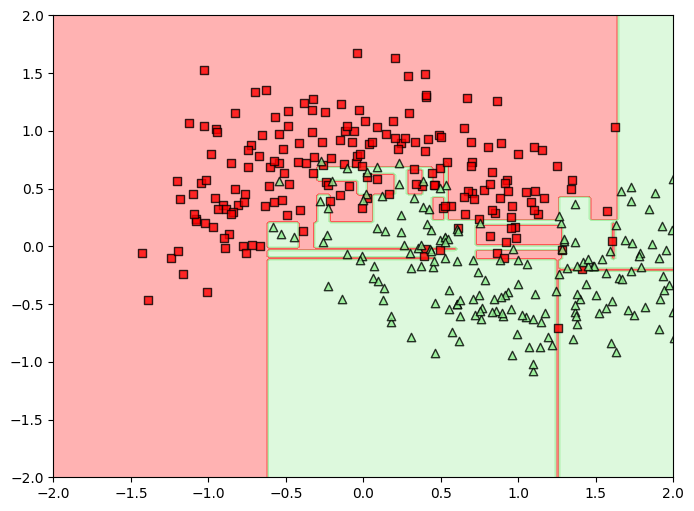

In [3]:
tree_clf = DecisionTreeClassifier(random_state=0)#no limito el crecimiento
tree_clf.fit(X_train, y_train)

# Graficación
plt.figure(figsize=(8,6))
plot_decision_regions(tree_clf, X_train, y_train, )
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()#veo que se sobreajustó

In [4]:
print(tree_clf.score(X_test, y_test))

0.88


**Vamos a comparar el entrenamiento de un árbol de decisión con un ensamble de árboles**

**Armamos un ensamble combinando 500 árboles de decisión**

Creamos el ensamble usando la clase **_BaggingClassifier_** implementado en el módulo scikit-Learn. Esta es una API para bagging y pasting en función de cómo se seleccionan los parámetros:

1. Cuando los subconjuntos se seleccionan de forma aleatoria particionando el dataset sin reemplazo, el algoritmo se conoce como **_Pasting_**
2. Cuando los subconjuntos se seleccionan de forma aleatoria particionando el dataset **_con_** reemplazo, el algoritmo se conoce como **_Bagging_**
3. Cuando los subconjuntos tienen diferentes características seleccionadas de forma aleatoria, el algoritmo se conoce como **_Random Subspaces_**
4. Cuando los subconjuntos combinan los dos anteriores, el algoritmo se conoce como **_Random Patches_**

In [6]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(estimator= DecisionTreeClassifier(), 
                            n_estimators=500, #500 arboles
                            max_samples=100, #100 n max de muestras de los datos de entrenamiento
                            max_features = 1.0, #1.0 porcentaje de caracteristicas-->bagging
                            bootstrap = True, #con reemplazo
                            n_jobs=-1, #no limito el crecimiento
                            random_state=0) #semilla
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=0)

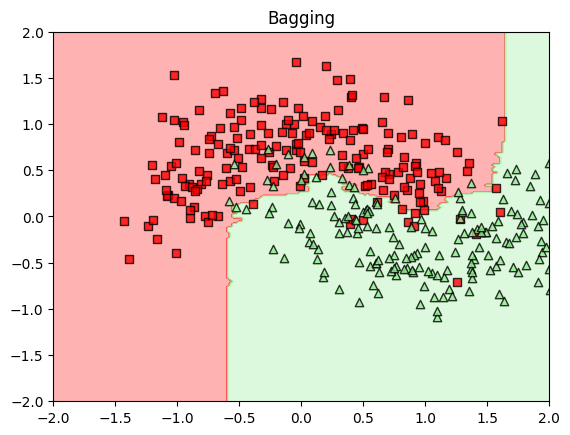

In [7]:
plot_decision_regions(bag_clf, X_train, y_train)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Bagging")
plt.ylabel("")

plt.show()

In [8]:
bag_clf.score(X_test, y_test)

0.904

### Evaluación Out of bag (OOB)

Es una medida del desempeño aplicada a modelos que utilizan la técnica de **_Bootstrapping_**. En la selección de los datos para cada clasificador, durante su entrenamiento, alrededor del 36% de los datos no son muestreados. El desempeño OOB, representa el promedio de los desempeños de cada clasificador del ensamble cuando se tienen en cuenta estos datos que cada clasificador no ve durante el entrenamiento. Esta estrategia puede entenderse como una especie de validación cruzada y es efectiva para estimar la generalización del modelo.

In [9]:
bag_clf = BaggingClassifier(estimator= DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100, 
                            max_features = 1.0,
                            bootstrap = True,
                            oob_score=True,
                            n_jobs=-1, 
                            random_state=0)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8826666666666667

In [10]:
bag_clf.estimators_samples_[0].shape #ver si coincide con el maximo número de muestras

(100,)

In [11]:
print(bag_clf.score(X_test, y_test))

0.904


## Random Forest

En esta estrategia, los clasificadores son árboles de decisión y los subconjuntos de entrenamiento se eligen por **_Bootstrapping_** o **_Random Subspacing_**.
El número de árboles suele ser grande, generalmente entre 100 a 1000 árboles de decisión.

Mediante el bootstrapping se introduce aletoriedad al algoritmo, haciendo que cada árbol se forme de manera ligeramente distinta ya que en la formación de los mismos cada uno parte de una muestra diferente y en cada nodo la selección de características cambia.

### Parámetros principales del modelo:

Este modelo depende principalmente de 2 parámetros:

- Número de árboles de decisión. En la función de scikit-learn por defecto es 100.
- Número de características (q) que se seleccionan en cada nodo y que permanece fijo en la formación del árbol. En la función de scikit-learn, toma por defecto $q=\sqrt{F}$ siendo F el número de características totales en el dataset.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, #500 arboles
                                 bootstrap=True, #con reemplazo
                                 max_leaf_nodes=16,#maximo 16 nodos hojas
                                 n_jobs=-1, 
                                 max_features='sqrt',
                                 oob_score=True,#para que devuelva el desempeño out of bag
                                 random_state=0)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=0)

In [13]:
rnd_clf.oob_score_

0.872

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16],
              'max_features': ['sqrt', 'log2', None]
              }


grid_search = GridSearchCV(
                           RandomForestClassifier(bootstrap=True, oob_score=True, random_state=0), 
                           param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           n_jobs=-1
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [15]:
grid_search.best_estimator_

RandomForestClassifier(max_features=None, max_leaf_nodes=8, n_estimators=300,
                       oob_score=True, random_state=0)

In [16]:
grid_search.best_estimator_.oob_score_

0.8853333333333333

In [17]:
print(grid_search.score(X_test, y_test))

0.896


### Importancia de las características

Otra utilidad de los Random Forest es que facilitan la medición de la importancia relativa de cada característica. Esta medición de la importancia de las características puede ser muy útil para comprender cuáles características tienen una mayor influencia en las predicciones del modelo. 

Scikit-Learn evalúa la importancia de una característica analizando cuánto reducen la impureza los nodos del árbol de decisión que utilizan esa característica en promedio a lo largo de todos los árboles en el Bosque Aleatorio. Se calcula un promedio ponderado, donde el peso de cada nodo se determina por el número de muestras de entrenamiento asociadas a él. En otras palabras, los nodos que tienen un mayor impacto en la clasificación de los datos reciben una importancia más alta.

Scikit-Learn calcula esta puntuación automáticamente para cada característica después del entrenamiento, luego escala los resultados para que la suma de todas las importancias sea igual a 1. Se puede acceder al resultado usando el atributo **feature_importances_**.

In [18]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=2)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.1 sepal length (cm)
0.02 sepal width (cm)
0.42 petal length (cm)
0.45 petal width (cm)


## Boosting:

Boosting se refiere a la forma en como un ensamble puede potenciar (boost) un clasificador 'débil' para obtener uno más robusto.

En la estrategia de Bagging, los clasificadores se entrenaban de forma independiente. En Boosting los clasificadores se entrenan en serie (consecutivamente) y la performance del clasificador _k_ influencia en el entrenamiento del _k+1_.

La idea general es entrenar clasificadores secuencialmente y que cada clasificador corrija a su clasificador predecesor.


<center><img src="https://drive.google.com/uc?export=view&id=1T1vTtnuPG6a_iAjclnVt17tSeikFrNVc" width = 600></center>

### Adaboost
Es el primer algoritmo que se volvió popular en 1997, creado por Freund y Schapire.

Como idea clave, el algoritmo se enfoca en las muestras mal clasificadas, de forma tal que estas sean muestreadas (up-sampled) cuando el siguiente clasificador es entrenado. Por lo tanto, los datos de entrenamiento de los clasificadores siguientes están orientados a instancias cada vez más difíciles de clasificar.

En el algoritmo, cada instancia del conjunto de entrenamiento tiene un peso $\frac{1}{m}$, con $m$ igual a la cantidad de instancias. Después del entrenamiento del primer clasificador, se calcula su tasa de error $r_j$: $$r_j=\frac{\sum\limits_{\begin{matrix}
i=1\\ y_{p}\neq y \end{matrix}}^{m}w^{(i)}}{\sum\limits_{i=1}^{m}w^{(i)}}$$

Después se calcula el peso para cada clasificador $\alpha_j$, $\eta$ es un coeficiente de aprendizaje del algoritmo: 

$$\alpha_j = \eta \log\frac{1-r_j}{r_j}$$

Con este coeficiente se actualizan los pesos de las instancias mal clasificadas: 

$$w^{(i)} = w^{(i)} exp(\alpha_j), \qquad y_p^{(i)} \neq y^{(i)}$$

Adaboost usa un esquema de votación no democrático, denominado _weighted majority voting_: aquellos clasificadores que mostraron buena performance durante su entrenamiento son "recompensados" con pesos de votación más altos que los demás.

[0.56137725 4.57317073]
[ 0.34678365  1.47270115  2.82501804 11.99712644]
[ 0.27543828  0.46800987  1.16971565  1.98751778  2.24381424  3.81256821
  9.5289031  16.19099848]
[ 0.2357266   0.33124074  0.40053393  0.56282641  1.00107035  1.4066944
  1.70096478  2.69840018  3.26288615  4.58497613 11.45941288 13.85663989]
[ 0.21040153  0.26798242  0.2956542   0.45534128  0.50235967  0.89352128
  1.13805254  1.25556747  1.93371752  2.40850003  3.70936554  4.09239342
 10.22828137 15.75272325]


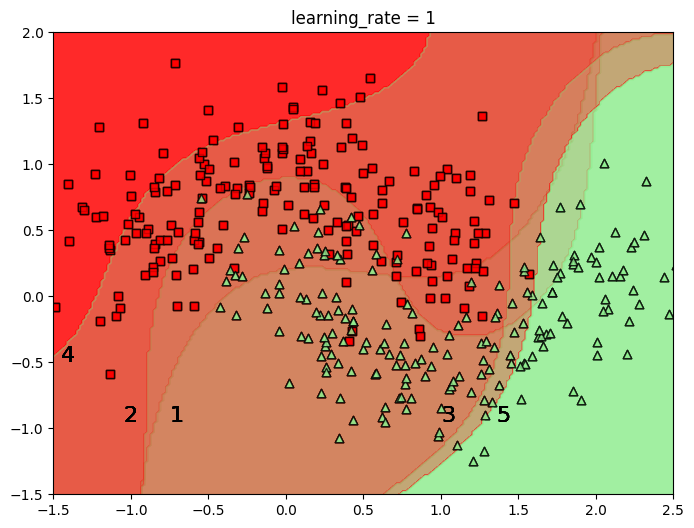

In [19]:
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)

plt.figure(figsize=(8,6))
learning_rate = 1 #coef de aprendizaje
    
pesos_instancias = np.ones(m) / m #inicializo pesos
    
for i in range(5):
    svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=pesos_instancias * m)#paso el vector de peso para cada dato de entrenamiento, 
                                                            #inicialmente todos en 1 para tener la misma prob de ser seleccionados
    y_pred = svm_clf.predict(X_train)

    errores = pesos_instancias[y_pred != y_train].sum()
    r = errores / pesos_instancias.sum() 
    alpha = learning_rate * np.log((1 - r) / r)
    
    #Actualización de los pesos
    pesos_instancias[y_pred != y_train] *= np.exp(alpha)
    #Se normalizan los pesos
    pesos_instancias /= pesos_instancias.sum() 
    print(np.unique(pesos_instancias*m))
    
    plot_decision_regions(svm_clf, X_train, y_train)
    plt.title(f"learning_rate = {learning_rate}")
    
    plt.text(-0.75, -0.95, "1", fontsize=16)
    plt.text(-1.05, -0.95, "2", fontsize=16)
    plt.text(1.0, -0.95, "3", fontsize=16)
    plt.text(-1.45, -0.5, "4", fontsize=16)
    plt.text(1.36,  -0.95, "5", fontsize=16)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2)
plt.show()

sklearn utiliza una versión de AdaBoost llamada SAMME _(Stagewise Additive Modeling using a Multiclass Exponential loss function)_ Si los clasificadores en el ensamble pueden realizar predicciones mediante probabilidades, sklearn utiliza la variante SAMME.R que tiene en cuenta las probabilidades en lugar de las predicciones y generalmente obtiene mejores desempeños.

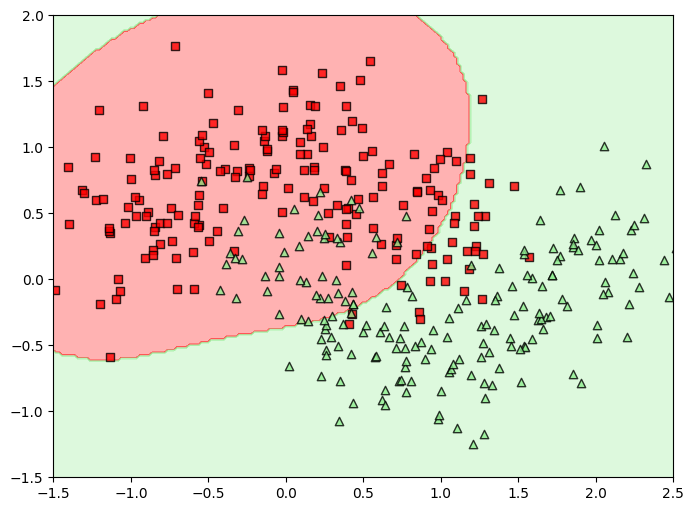

0.832


In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier( SVC(C=0.2, gamma=0.6, probability=True, random_state=42), 
                              n_estimators=100,
                              learning_rate=1, 
                              random_state=42,
                              algorithm='SAMME.R'
                             )
ada_clf.fit(X_train, y_train)

plt.figure(figsize=(8,6))
plot_decision_regions(ada_clf, X_train, y_train)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2)
plt.show()

print(ada_clf.score(X_test, y_test))

In [ ]:
param_grid = {  'n_estimators': [10, 20, 30, 40, 50, 100],
                'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                'estimator__C': [0.001, 0.01, 0.1, 1, 10],
                'estimator__gamma': [0.001, 0.01, 0.1, 1, 10]
             }

grid_search = GridSearchCV( AdaBoostClassifier( SVC(probability=True, random_state=42)),
                            param_grid, 
                            cv=5, 
                            scoring='accuracy',
                            n_jobs=-1
                           )    

grid_search.fit(X_train, y_train)

In [21]:
grid_search.best_estimator_

RandomForestClassifier(max_features=None, max_leaf_nodes=8, n_estimators=300,
                       oob_score=True, random_state=0)

In [22]:
print(grid_search.score(X_test, y_test))

0.88


### Clasificadores por Votación

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [24]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Si queremos usar `soft-voting` (devuelve la etiqueta de clase como el argmax de la suma de las probabilidades predichas)

In [25]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True#cambio para que pueda usar las probabilidades
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Stacking

Es un método para combinar clasificadores con el fin de reducir sus sesgos. Las predicciones de cada clasificador individual se apilan y se utilizan como entrada para entrenar un clasificador final que calcula la predicción. Este clasificador final se entrena mediante validación cruzada.

In [26]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [27]:
stacking_clf.score(X_test, y_test)

0.928